# HW1 - Frequent Patterns

**Nick Satriano** and **Jake Luther**

Class: CSCI 349 - Intro to Data Mining  
Semester: Spring 2023
Instructor: Brian King  

# Part 2

**_Part 1 is appended to the end of the PDF_**

In [75]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import zscore
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import pdist, squareform
from mpl_toolkits.mplot3d import Axes3D
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

## Phase 1 - EDA

In [76]:
# Reading in the data
links_df = pd.read_csv("../data/ml-latest-small/links.csv")
movies_df = pd.read_csv("../data/ml-latest-small/movies.csv")
ratings_df = pd.read_csv("../data/ml-latest-small/ratings.csv")
tags_df = pd.read_csv("../data/ml-latest-small/tags.csv")

**Preprocessing the data:**

In [77]:
# Creating links DataFrame
links_df['movieId'] = links_df['movieId'].astype('category')
links_df['imdbId'] = links_df['imdbId'].astype('category')
links_df['tmdbId'] = links_df['tmdbId'].astype('category')
links_df = links_df.set_index('movieId')
links_df.info()

# Creating movies DataFrame
movies_df['movieId'] = movies_df['movieId'].astype('category')
movies_df['title'] = movies_df['title'].astype('string')
movies_df = movies_df.set_index('movieId')
movies_df.info()

# Creating ratings DataFrame
ratings_df['movieId'] = ratings_df['movieId'].astype('category')
ratings_df['userId'] = ratings_df['userId'].astype('category')
ratings_df.info()
ratings_df.head()

# Creating the tags DataFrame
tags_df['movieId'] = tags_df['movieId'].astype('category')
tags_df['userId'] = tags_df['userId'].astype('category')
tags_df['tag'] = tags_df['tag'].astype('string')
tags_df.info()

<class 'pandas.core.frame.DataFrame'>
CategoricalIndex: 9742 entries, 1 to 193609
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   imdbId  9742 non-null   category
 1   tmdbId  9734 non-null   category
dtypes: category(2)
memory usage: 1.0 MB
<class 'pandas.core.frame.DataFrame'>
CategoricalIndex: 9742 entries, 1 to 193609
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   9742 non-null   string
 1   genres  9742 non-null   object
dtypes: object(1), string(1)
memory usage: 505.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype   
---  ------     --------------   -----   
 0   userId     100836 non-null  category
 1   movieId    100836 non-null  category
 2   rating     100836 non-null  float64 
 3   timestamp  100836 non-null  int64   
dtypes: category(2),

**General information about our data:**

In [78]:
# General Data
print("Total number of movies: ", len(movies_df))
print("Total number of users: ", ratings_df['userId'].nunique())
print("Total number of reviews: ", len(ratings_df))

Total number of movies:  9742
Total number of users:  610
Total number of reviews:  100836


**Distribution of the number of ratings per movie:**

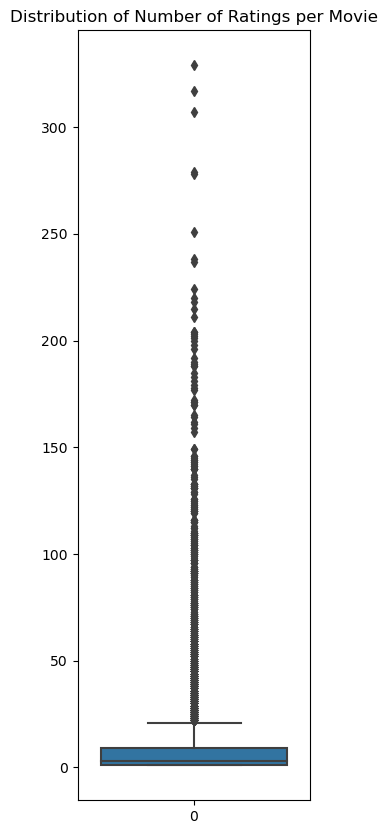

Average number of ratings per movie =  10.38
Median number of ratings per movie =  3.0

Movies with the MOST number of ratings:
 Forrest Gump (1994)                 329
Shawshank Redemption, The (1994)    317
Pulp Fiction (1994)                 307
Silence of the Lambs, The (1991)    279
Matrix, The (1999)                  278
Name: title, dtype: Int64

Movies with the LEAST number of ratings:
 31 (2016)                         1
Extraordinary Tales (2015)        1
Sex, Drugs & Taxation (2013)      1
How To Change The World (2015)    1
Chasuke's Journey (2015)          1
Name: title, dtype: Int64


In [79]:
# Number of Ratings per Movie
movie_ratings = pd.merge(ratings_df, movies_df['title'], on='movieId')
num_rates_by_movie = movie_ratings['title'].value_counts()
fig, ax = plt.subplots(figsize=(3,10))
sns.boxplot(data=num_rates_by_movie, ax=ax)
plt.title("Distribution of Number of Ratings per Movie")
plt.show()
print("Average number of ratings per movie = ", round(num_rates_by_movie.mean(), 2))
print("Median number of ratings per movie = ", num_rates_by_movie.median())
print("\nMovies with the MOST number of ratings:\n", num_rates_by_movie.head())
print("\nMovies with the LEAST number of ratings:\n", num_rates_by_movie.sort_values().head())

From our distribution, we can see that _"Forrest Gump (1994)"_, _"Shawshank Redemption, The (1994)"_, and _"Pulp Fiction (1994)"_ were the three most reviewed movies, and there were numerous movies that had only one review. The average number of ratings per movie was 10.38, and the median number of ratings was 3.0. From our boxplot, we can see that our data is very skewed, so it is best to consider the median as the measure of center for the distribution of our data when looking at number of ratings per movie.

**Movies with the highest and lowest average ratings:**

In [80]:
avg_mv_ratings = movie_ratings.groupby('movieId')['rating'].mean()
movies_df = pd.merge(movies_df, avg_mv_ratings, on='movieId')

In [81]:
lowest_avg_mv_ratings = movies_df.sort_values(by='rating')
highest_avg_mv_ratings = avg_mv_ratings.sort_values(ascending=False)
print("Movies with the LOWEST average rating:\n", movies_df[['title', 'rating']].sort_values(by='rating', ascending=True).head())
print("\nMovies with the HIGHEST average rating:\n", movies_df[['title', 'rating']].sort_values(by='rating', ascending=False).head())

Movies with the LOWEST average rating:
                            title  rating
movieId                                 
26696           Lionheart (1990)     0.5
3604                Gypsy (1962)     0.5
7312     Follow Me, Boys! (1966)     0.5
145724     Idaho Transfer (1973)     0.5
76030             Case 39 (2009)     0.5

Movies with the HIGHEST average rating:
                                          title  rating
movieId                                               
88448    Paper Birds (Pájaros de papel) (2010)     5.0
100556              Act of Killing, The (2012)     5.0
143031                         Jump In! (2007)     5.0
143511                            Human (2015)     5.0
143559                     L.A. Slasher (2015)     5.0


We can see that _"Lionheart (1990)"_, _"Gypsy (1962)"_, and _"Follow Me, Boys! (1966)"_ are among the lowest overall rated movies. On the other hand, _"Paper Birds (Pájaros de papel) (2010)"_, _"Act of Killing, The (2012)"_, and _"Jump In! (2007)"_ are among the highest rated movies.

**Distribution of number of ratings per user:**

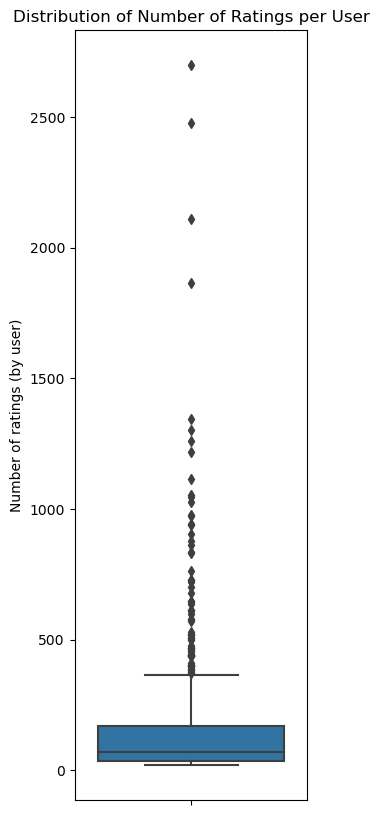

In [82]:
# Number of Ratings per User
movies_by_user = movie_ratings.groupby('userId').count()
fig, ax = plt.subplots(figsize=(3,10))
sns.boxplot(data=movies_by_user, ax=ax, y='title')
plt.title("Distribution of Number of Ratings per User")
plt.ylabel('Number of ratings (by user)')
plt.show()

We can see that the distribution of number of ratings per user is very heavily right skewed. Most of our observations indicate that the number of reviews is heavily concentrated between 1 and 400, though there are many outliers which lay above 400, and even 500 movie reviews.

**Distribution of the number of movies watched per user:**

In [83]:
print("Average number of movie ratings per user = ", round(movies_by_user.mean(), 2))
print("Median number of movie ratings per user = ", movies_by_user.median())
print("Max number of movies rated by a user = ", movies_by_user.max())
print("Min number of movies rated by a user = ", movies_by_user.min())

Average number of movie ratings per user =  movieId      165.3
rating       165.3
timestamp    165.3
title        165.3
dtype: float64
Median number of movie ratings per user =  movieId      70.5
rating       70.5
timestamp    70.5
title        70.5
dtype: float64
Max number of movies rated by a user =  movieId      2698
rating       2698
timestamp    2698
title        2698
dtype: int64
Min number of movies rated by a user =  movieId      20
rating       20
timestamp    20
title        20
dtype: int64


**Adding genre dummies to the movies DataFrame for each observation:**

In [84]:
# Number of Ratings by Genre
genre_dummies = movies_df['genres'].str.get_dummies('|')
movies_df = pd.concat([movies_df, genre_dummies], axis=1)
movies_df.head()

,title,genres,rating,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.920930,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,Jumanji (1995),Adventure|Children|Fantasy,3.431818,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Grumpier Old Men (1995),Comedy|Romance,3.259615,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,Waiting to Exhale (1995),Comedy|Drama|Romance,2.357143,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
5,Father of the Bride Part II (1995),Comedy,3.071429,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


The first 5 observations of our appended movies DataFrame is seen above.

**Adding the genre dummies to the movie_ratings DataFrame:**

In [85]:
movie_ratings = pd.merge(movie_ratings, genre_dummies, on='movieId', how='left')
movie_ratings

,userId,movieId,rating,timestamp,title,(no genres listed),Action,Adventure,Animation,Children,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1,4.0,964982703,Toy Story (1995),0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,5,1,4.0,847434962,Toy Story (1995),0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,7,1,4.5,1106635946,Toy Story (1995),0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,15,1,2.5,1510577970,Toy Story (1995),0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,17,1,4.5,1305696483,Toy Story (1995),0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100831,610,160341,2.5,1479545749,Bloodmoon (1997),0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
100832,610,160527,4.5,1479544998,Sympathy for the Underdog (1971),0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100833,610,160836,3.0,1493844794,Hazard (2005),0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
100834,610,163937,3.5,1493848789,Blair Witch (2016),0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0


The first 5 observations of our appended movie_ratings DataFrame is seen above.

**Showing the distribution of the number of ratings per genre:**

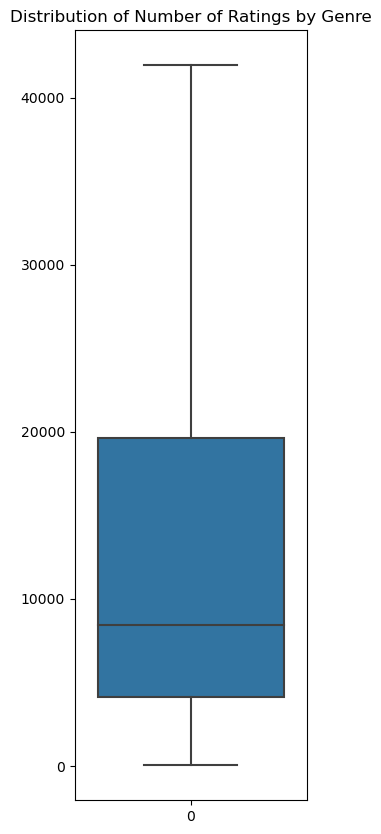

Average number of ratings per genre =  13724.0
Median number of ratings per genre =  8441.0
Max total number of ratings of a genre =  41928
Min total number of ratings of a genre =  47


In [86]:
num_ratings_by_genre = movie_ratings.loc[:,'(no genres listed)':].sum(axis=0)
fig, ax = plt.subplots(figsize=(3,10))
sns.boxplot(data=num_ratings_by_genre, ax=ax)
plt.title("Distribution of Number of Ratings by Genre")
plt.show()
print("Average number of ratings per genre = ", round(num_ratings_by_genre.mean(), 2))
print("Median number of ratings per genre = ", num_ratings_by_genre.median())
print("Max total number of ratings of a genre = ", num_ratings_by_genre.max())
print("Min total number of ratings of a genre = ", num_ratings_by_genre.min())

**Showing the number of ratings for each genre:**

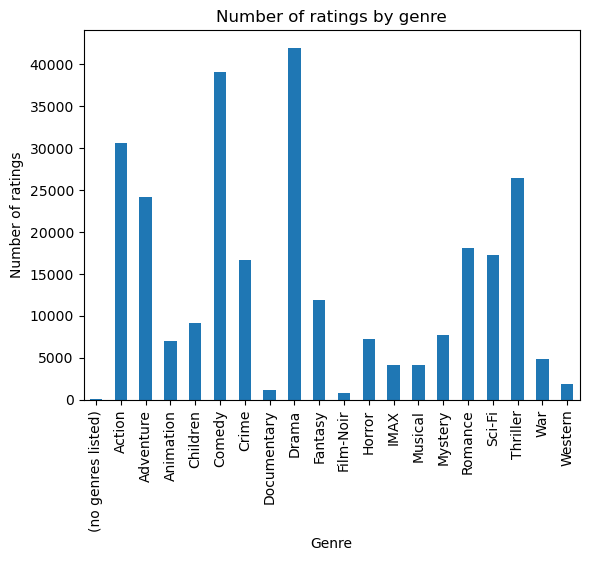

In [87]:
num_ratings_by_genre.plot(kind='bar')
plt.title('Number of ratings by genre')
plt.xlabel('Genre')
plt.ylabel('Number of ratings')
plt.show()

Drama, Comedy, and Action are the three most reviewed movie genres in order.

**Distribution of ratings for each specific genre:**

In [88]:
# Ratings by Genre
genre_df = pd.DataFrame({'genres':genre_dummies.columns})
genre_df = genre_df.set_index('genres')
for x in np.arange(0.5, 5.5, 0.5):
    genre_df[str(x)] = [0] * len(genre_df)
    for g in genre_df.index:
        rating_df = movie_ratings[movie_ratings['rating'] == x]
        genre_df.loc[g, str(x)] = len(rating_df[rating_df[g]==1])
print("Distribution of each rating by genre:\n", genre_df)

Distribution of each rating by genre:
                     0.5   1.0  1.5   2.0   2.5   3.0   3.5    4.0   4.5   5.0
genres                                                                       
(no genres listed)    2     2    0     2     6     6     6      8     8     7
Action              449   904  577  2548  1777  6331  4153   7678  2468  3750
Adventure           306   627  415  1769  1352  4838  3285   6392  2027  3150
Animation            80   116   96   346   365  1279  1051   1988   682   985
Children            169   301  161   721   530  2054  1205   2358   648  1061
Comedy              632  1317  895  3405  2530  8306  5086   9659  2794  4429
Crime               152   321  204   982   772  3116  2057   4621  1769  2687
Documentary           6    16    2    33    42   163   228    415   161   153
Drama               405   795  485  2339  1922  7541  5514  12360  4217  6350
Fantasy             178   286  214   893   719  2364  1634   2988  1040  1518
Film-Noir             8  

The above DataFrame shows the distribution of the number of ratings for each movie on a scale of 0.5 to 5.0.

**Here is the Distribution of Every Different Genre:**

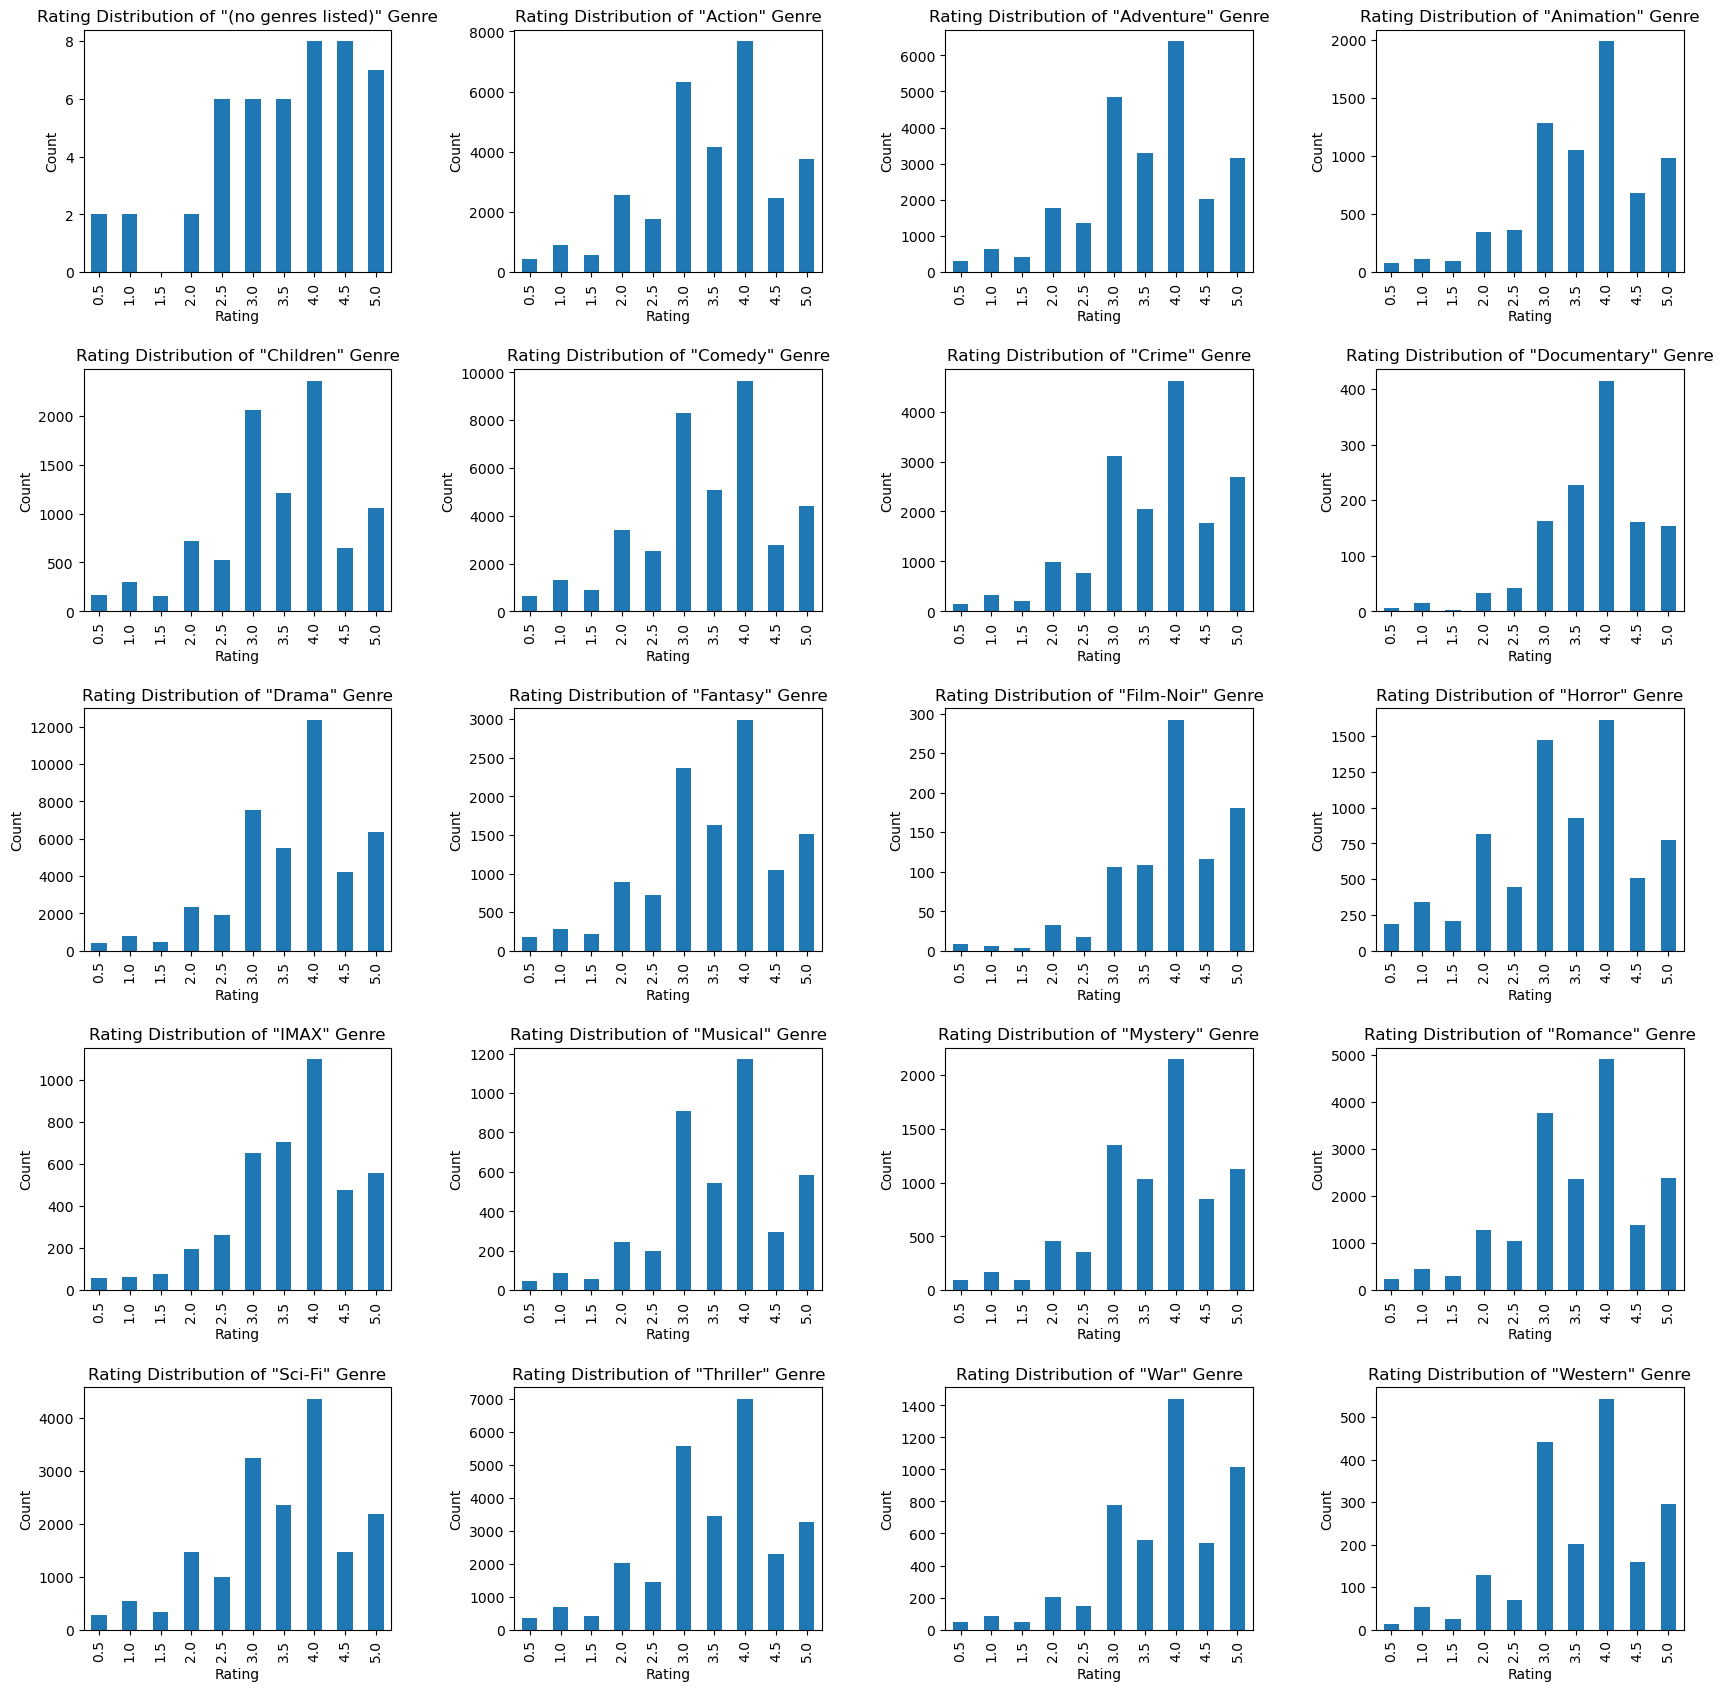

In [110]:
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(20, 20))
for i, ax in enumerate(axs.flatten()):#genre_df.index:
    g = genre_df.index[i]
    genre_df.loc[g, :].plot(kind='bar', ax=ax)
    ax.set_title('Rating Distribution of "{}" Genre'.format(g))
    ax.set_xlabel('Rating')
    ax.set_ylabel('Count')
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=0.4)
plt.show()

**Showing the distribution of all movie ratings in the data:**

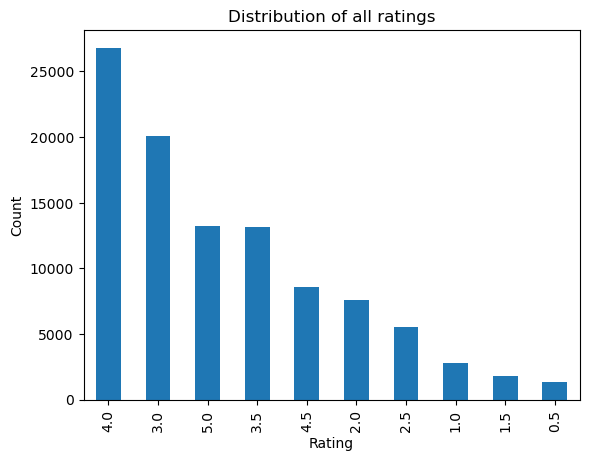

In [89]:
rating_counts = movie_ratings['rating'].value_counts()
rating_counts.plot(kind='bar')
plt.title('Distribution of all ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

## Phase 2

**Convert the ratings file into a set of transactions, with each transaction representing one customer, and where the universe of all possible items are movies:**

In [90]:
user_ratings_df = ratings_df.groupby('userId')['movieId'].apply(list).reset_index()

user_df = user_ratings_df.rename(columns={'movieId': 'movies'})

user_df = user_df.set_index('userId')

print("Here are the first 5 observations of our new DataFrame:\n", user_df.head())

Here are the first 5 observations of our new DataFrame:
                                                    movies
userId                                                   
1       [1, 3, 6, 47, 50, 70, 101, 110, 151, 157, 163,...
2       [318, 333, 1704, 3578, 6874, 8798, 46970, 4851...
3       [31, 527, 647, 688, 720, 849, 914, 1093, 1124,...
4       [21, 32, 45, 47, 52, 58, 106, 125, 126, 162, 1...
5       [1, 21, 34, 36, 39, 50, 58, 110, 150, 153, 232...


The new DataFrame "user_df" contains the userId as the index for each observation and a single element, "movies", which is a column of lists containing of every movieId that the user reviewed for each userId.

**Generate the top 20 most frequent patterns:**

In [91]:
te = TransactionEncoder()
te_ary = te.fit(user_df['movies']).transform(user_df['movies'])
df = pd.DataFrame(te_ary, columns=te.columns_)
df

df_freq = apriori(df, min_support=0.3, use_colnames=True)

df_freq = df_freq.sort_values(by = 'support', ascending = False)

df_freq.head(20)

,support,itemsets
8,0.539344,(356)
7,0.519672,(318)
6,0.503279,(296)
15,0.457377,(593)
22,0.455738,(2571)
5,0.411475,(260)
10,0.390164,(480)
3,0.388525,(110)
34,0.378689,"(356, 318)"
32,0.377049,"(296, 356)"


**Output the strongest association rules:**

In [92]:
rules = association_rules(df_freq, metric="confidence", min_threshold=0.7)

rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(356),(318),0.539344,0.519672,0.378689,0.702128,1.351097,0.098406,1.612529
1,(318),(356),0.519672,0.539344,0.378689,0.728707,1.351097,0.098406,1.697998
2,(296),(356),0.503279,0.539344,0.377049,0.749186,1.389068,0.105609,1.836640
3,(296),(318),0.503279,0.519672,0.363934,0.723127,1.391506,0.102395,1.734831
4,(318),(296),0.519672,0.503279,0.363934,0.700315,1.391506,0.102395,1.657481
5,(593),(296),0.457377,0.503279,0.339344,0.741935,1.474204,0.109156,1.924795
6,(593),(318),0.457377,0.519672,0.326230,0.713262,1.372522,0.088543,1.675143
7,(593),(356),0.457377,0.539344,0.326230,0.713262,1.322461,0.079546,1.606537
8,(480),(356),0.390164,0.539344,0.324590,0.831933,1.542489,0.114157,2.740902
9,(1196),(260),0.345902,0.411475,0.311475,0.900474,2.188403,0.169145,5.913271


The above DataFrame contains the output of the association_rules function on our data for rules with a minimum confidence of 0.7.

**Adding new columns to the rules DataFrame for print formatting:**

In [93]:
# Adding new columns to our DataFrame
for col in ['antecedents', 'consequents']:
    rules['movieId'] = rules[col].apply(lambda x: list(x)[0])
    rules = pd.merge(rules, movies_df['title'], on='movieId', how='left', suffixes=['_antecedents', '_consequents'])
    rules[col+str(2)] = rules['movieId']
rules = rules.drop(columns=['movieId', 'antecedents2', 'consequents2'])
for idx in rules.index:
    ants = [rules.loc[idx, 'title_antecedents']]
    cons = [rules.loc[idx, 'title_consequents']]
    print("Rule #", idx, ": ", ants," -> ",cons, "\n\t  confidence = ", rules.loc[idx,'confidence'],"\tlift = ", rules.loc[idx,'lift'],'\n')

Rule # 0 :  ['Forrest Gump (1994)']  ->  ['Shawshank Redemption, The (1994)'] 
	  confidence =  0.7021276595744682 	lift =  1.351097389086516 

Rule # 1 :  ['Shawshank Redemption, The (1994)']  ->  ['Forrest Gump (1994)'] 
	  confidence =  0.7287066246056783 	lift =  1.351097389086516 

Rule # 2 :  ['Pulp Fiction (1994)']  ->  ['Forrest Gump (1994)'] 
	  confidence =  0.749185667752443 	lift =  1.3890676514558975 

Rule # 3 :  ['Pulp Fiction (1994)']  ->  ['Shawshank Redemption, The (1994)'] 
	  confidence =  0.723127035830619 	lift =  1.3915062834595509 

Rule # 4 :  ['Shawshank Redemption, The (1994)']  ->  ['Pulp Fiction (1994)'] 
	  confidence =  0.7003154574132493 	lift =  1.3915062834595509 

Rule # 5 :  ['Silence of the Lambs, The (1991)']  ->  ['Pulp Fiction (1994)'] 
	  confidence =  0.7419354838709677 	lift =  1.4742040558999685 

Rule # 6 :  ['Silence of the Lambs, The (1991)']  ->  ['Shawshank Redemption, The (1994)'] 
	  confidence =  0.7132616487455198 	lift =  1.37252241

From the association rules that we generated, we can see that **['Star Wars: Episode V - The Empire Strikes Back (1980)']  ->  ['Star Wars: Episode IV - A New Hope (1977)']** is clearly the strongest association rule, as it has a **confidence of 0.9** and a **lift of 2.19.** Generally, we consider association rules with **confidence > 0.7** and **lift > 1.25** to be very strong association rules. From this, we can deduce that the above rules that we have listed are all quite strong.

# Phase 3 - Genre

**Selecting the "Action", "Drama", and "Crime" genres and finding association rules for each:**

In [94]:
for g in ['Action', 'Drama', 'Crime']:
    print("Strongest association rules for ", g," movies:\n")
    g_ratings_df = movie_ratings[movie_ratings[g]==1].groupby('userId')['movieId'].apply(list).reset_index()

    # Rename the movieId column to movies_watched
    g_df = g_ratings_df.rename(columns={'movieId': 'movies'})

    g_df = g_df.set_index('userId')
   
    te2 = TransactionEncoder()
    te_ary2 = te2.fit(g_df['movies']).transform(g_df['movies'])
    df2 = pd.DataFrame(te_ary2, columns=te2.columns_)

    df_freq2 = apriori(df2, min_support=0.3, use_colnames=True)

    df_freq2 = df_freq2.sort_values(by = 'support', ascending = False)
   
    # Getting Strongest Association Rules
    rules2 = association_rules(df_freq2, metric="confidence", min_threshold=0.7)
    for col in ['antecedents', 'consequents']:
        rules2['movieId'] = rules2[col].apply(lambda x: list(x)[0])
        rules2 = pd.merge(rules2, movies_df['title'], on='movieId', how='left', suffixes=['_antecedents', '_consequents'])
        rules2[col+str(2)] = rules2['movieId']
    rules2 = rules2.drop(columns=['movieId', 'antecedents2', 'consequents2'])
    for idx in rules2.index:
        ants = [rules2.loc[idx, 'title_antecedents']]
        cons = [rules2.loc[idx, 'title_consequents']]
        print("Rule #", idx, ": ", ants," -> ",cons, "\n\t  confidence = ", rules2.loc[idx,'confidence'],"\tlift = ", rules2.loc[idx,'lift'],'\n')
    print("\n")

Strongest association rules for  Action  movies:

Rule # 0 :  ['Star Wars: Episode V - The Empire Strikes Back (1980)']  ->  ['Star Wars: Episode IV - A New Hope (1977)'] 
	  confidence =  0.9004739336492892 	lift =  2.18840278695644 

Rule # 1 :  ['Star Wars: Episode IV - A New Hope (1977)']  ->  ['Star Wars: Episode V - The Empire Strikes Back (1980)'] 
	  confidence =  0.7569721115537849 	lift =  2.18840278695644 

Rule # 2 :  ['Star Wars: Episode IV - A New Hope (1977)']  ->  ['Matrix, The (1999)'] 
	  confidence =  0.7290836653386454 	lift =  1.5997878987646537 



Strongest association rules for  Drama  movies:

Rule # 0 :  ['Forrest Gump (1994)']  ->  ['Shawshank Redemption, The (1994)'] 
	  confidence =  0.7021276595744682 	lift =  1.351097389086516 

Rule # 1 :  ['Shawshank Redemption, The (1994)']  ->  ['Forrest Gump (1994)'] 
	  confidence =  0.7287066246056783 	lift =  1.351097389086516 

Rule # 2 :  ['Pulp Fiction (1994)']  ->  ['Forrest Gump (1994)'] 
	  confidence =  0.7

This method for finding association rules within the movie review dataset might paint us a better picture of the association rules between the movies because most of the movies have multiple genres. To add to this, find some more meaning in our data analysis by adding the grouping by genre to better understand how similar-genre movies' viewership might be associated. However, this method may also filter out some strong association rules that exist between movies of different genres.

# Phase 4 - Genre Rules

**Creating a new DataFrame that contains the list of genres reviewed by each userId:**

In [95]:
# Creating a new DataFrame containing the list of unique genres reviewed by each userId
movie_dat_df = pd.merge(movies_df, ratings_df, on='movieId')

movie_dat_df = movie_dat_df.groupby('userId').apply(lambda x: list(set(x['genres'].str.split('|').sum())))

movie_dat_df

userId
1      [War, Film-Noir, Adventure, Animation, Romance...
2      [War, Adventure, Western, Romance, Thriller, I...
3      [War, Adventure, Animation, Sci-Fi, Thriller, ...
4      [Film-Noir, Western, Sci-Fi, Romance, Comedy, ...
5      [War, Adventure, Animation, Romance, Thriller,...
                             ...                        
606    [Film-Noir, Western, Romance, Sci-Fi, Comedy, ...
607    [War, Adventure, Animation, Romance, IMAX, Chi...
608    [Film-Noir, Western, Romance, Sci-Fi, Comedy, ...
609    [War, Adventure, Animation, Documentary, Thril...
610    [Film-Noir, Western, Sci-Fi, Romance, Comedy, ...
Length: 610, dtype: object

**Finding frequent patterns among the genres reviewed by each userId:**

In [96]:
tencoder = TransactionEncoder()
te_arry = tencoder.fit(movie_dat_df).transform(movie_dat_df)
gdat_df = pd.DataFrame(te_arry, columns=tencoder.columns_)

df_gfreq = apriori(gdat_df, min_support=0.8, use_colnames=True)

df_gfreq = df_gfreq.sort_values(by = 'support', ascending = False)

df_gfreq.head(10)

,support,itemsets
6,1.000000,(Drama)
4,0.998361,(Comedy)
80,0.998361,"(Thriller, Drama)"
59,0.998361,"(Comedy, Drama)"
12,0.998361,(Thriller)
0,0.996721,(Action)
65,0.996721,"(Thriller, Comedy)"
332,0.996721,"(Thriller, Comedy, Drama)"
19,0.996721,"(Action, Drama)"
156,0.995082,"(Thriller, Action, Drama)"


**Generating the association rules for genre's frequent patterns:**

In [97]:
grules = association_rules(df_gfreq, metric="confidence", min_threshold=0.7)

grules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Thriller),(Drama),0.998361,1.000000,0.998361,1.000000,1.000000,0.000000,inf
1,(Drama),(Thriller),1.000000,0.998361,0.998361,0.998361,1.000000,0.000000,1.000000
2,(Comedy),(Drama),0.998361,1.000000,0.998361,1.000000,1.000000,0.000000,inf
3,(Drama),(Comedy),1.000000,0.998361,0.998361,0.998361,1.000000,0.000000,1.000000
4,(Thriller),(Comedy),0.998361,0.998361,0.996721,0.998358,0.999997,-0.000003,0.998361
...,...,...,...,...,...,...,...,...,...
686933,(Children),"(War, Drama, Crime, Comedy, Fantasy)",0.916393,0.855738,0.800000,0.872987,1.020158,0.015808,1.135812
686934,(Drama),"(War, Children, Crime, Comedy, Fantasy)",1.000000,0.800000,0.800000,0.800000,1.000000,0.000000,1.000000
686935,(Crime),"(War, Children, Drama, Comedy, Fantasy)",0.988525,0.803279,0.800000,0.809287,1.007480,0.005939,1.031504
686936,(Comedy),"(War, Children, Drama, Crime, Fantasy)",0.998361,0.801639,0.800000,0.801314,0.999594,-0.000325,0.998361


**Finding the strongest association rules and formatting the output:**

In [98]:
# Getting Strongest Association Rules
print(grules.index)
for idx in grules.index[:10]:
    ants = [list(grules.loc[idx, 'antecedents'])[0]]
    cons = [list(grules.loc[idx, 'consequents'])[0]]
    print("Rule #", idx, ": ", ants," -> ",cons, "\n\t  confidence = ", grules.loc[idx,'confidence'],"\tlift = ", grules.loc[idx,'lift'],'\n')

RangeIndex(start=0, stop=686938, step=1)
Rule # 0 :  ['Thriller']  ->  ['Drama'] 
	  confidence =  1.0 	lift =  1.0 

Rule # 1 :  ['Drama']  ->  ['Thriller'] 
	  confidence =  0.9983606557377049 	lift =  1.0 

Rule # 2 :  ['Comedy']  ->  ['Drama'] 
	  confidence =  1.0 	lift =  1.0 

Rule # 3 :  ['Drama']  ->  ['Comedy'] 
	  confidence =  0.9983606557377049 	lift =  1.0 

Rule # 4 :  ['Thriller']  ->  ['Comedy'] 
	  confidence =  0.9983579638752053 	lift =  0.9999973037173648 

Rule # 5 :  ['Comedy']  ->  ['Thriller'] 
	  confidence =  0.9983579638752053 	lift =  0.9999973037173648 

Rule # 6 :  ['Thriller']  ->  ['Drama'] 
	  confidence =  1.0 	lift =  1.0 

Rule # 7 :  ['Thriller']  ->  ['Comedy'] 
	  confidence =  0.9983579638752053 	lift =  0.9999973037173648 

Rule # 8 :  ['Comedy']  ->  ['Thriller'] 
	  confidence =  0.9983579638752053 	lift =  0.9999973037173648 

Rule # 9 :  ['Thriller']  ->  ['Comedy'] 
	  confidence =  0.9983579638752053 	lift =  0.9999973037173648 



From the association rules printed above, we can see that the strongest rules are **['Drama']  ->  ['Thriller']**, **['Thriller']  ->  ['Drama']**, and **['Comedy']  ->  ['Drama']**. The association rules that we are able to make about genres aren't quite optimal just yet, so we can't definitively say that these are the strongest association rules for genres.

# Phase 5 - Incorporating Additional Variables

**Defining a new function, get_decade() to find the decades that each userId reviewed:**

In [99]:
import re
# Define function to extract decade from movie title
def get_decade(title):
    year = re.findall(r"\(\d{4}\)", title)
    if len(year) > 0:
        year = int(year[0][1:5])
        decade = (year // 10) * 10
        return decade
    else:
        return None

**Adding the decade column to the movies_df:**

In [100]:
# Add decade column to movies DataFrame
movies_df["decade"] = movies_df["title"].apply(get_decade)

# Merge movies and ratings DataFrames
merged_df = ratings_df.merge(movies_df, on="movieId", how="left")

merged_df.head()

,userId,movieId,rating_x,timestamp,title,genres,rating_y,(no genres listed),Action,Adventure,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,decade
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.920930,0,0,1,...,0,0,0,0,0,0,0,0,0,1990.0
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance,3.259615,0,0,0,...,0,0,0,0,1,0,0,0,0,1990.0
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller,3.946078,0,1,0,...,0,0,0,0,0,0,1,0,0,1990.0
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,3.975369,0,0,0,...,0,0,0,1,0,0,1,0,0,1990.0
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,4.237745,0,0,0,...,0,0,0,1,0,0,1,0,0,1990.0


**Making a new DataFrame, decade_df, which contains the list of decades for each movie that was reviewed per userId:**

In [101]:
decade_df = merged_df.groupby('userId')['decade'].apply(list).reset_index()

decade_df = decade_df.set_index('userId')

decade_df

,decade
userId,
1,"[1990.0, 1990.0, 1990.0, 1990.0, 1990.0, 1990...."
2,"[1990.0, 1990.0, 1990.0, 2000.0, 2000.0, 2000...."
3,"[1990.0, 1990.0, 1990.0, 1990.0, 1990.0, 1990...."
4,"[1990.0, 1990.0, 1990.0, 1990.0, 1990.0, 1990...."
5,"[1990.0, 1990.0, 1990.0, 1990.0, 1990.0, 1990...."
...,...
606,"[1990.0, 1990.0, 1990.0, 1990.0, 1990.0, 1990...."
607,"[1990.0, 1990.0, 1990.0, 1990.0, 1990.0, 1990...."
608,"[1990.0, 1990.0, 1990.0, 1990.0, 1990.0, 1990...."


**Generating the transaction encoder and rules for the decade variable:**

In [102]:
te = TransactionEncoder()
te_ary = te.fit(decade_df['decade']).transform(decade_df['decade'])
df = pd.DataFrame(te_ary, columns=te.columns_)
df


decade_freq = apriori(df, min_support=0.7, use_colnames=True)

decade_freq = decade_freq.sort_values(by = 'support', ascending = False)


decade_rules = association_rules(decade_freq, metric="confidence", min_threshold=0.7)

decade_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(1980.0),(1990.0),0.908197,0.998361,0.908197,1.000000,1.001642,0.001489,inf
1,(1990.0),(1980.0),0.998361,0.908197,0.908197,0.909688,1.001642,0.001489,1.016513
2,(1970.0),(1990.0),0.775410,0.998361,0.775410,1.000000,1.001642,0.001271,inf
3,(1990.0),(1970.0),0.998361,0.775410,0.775410,0.776683,1.001642,0.001271,1.005702
4,(1970.0),(1980.0),0.775410,0.908197,0.726230,0.936575,1.031247,0.022005,1.447432
5,(1980.0),(1970.0),0.908197,0.775410,0.726230,0.799639,1.031247,0.022005,1.120927
6,(2000.0),(1990.0),0.726230,0.998361,0.726230,1.000000,1.001642,0.001191,inf
7,(1990.0),(2000.0),0.998361,0.726230,0.726230,0.727422,1.001642,0.001191,1.004375
8,"(1970.0, 1980.0)",(1990.0),0.726230,0.998361,0.726230,1.000000,1.001642,0.001191,inf
9,"(1970.0, 1990.0)",(1980.0),0.775410,0.908197,0.726230,0.936575,1.031247,0.022005,1.447432


Shown above are the association rules generated for the decade variable with a minimum support of 0.7 and a minimum confidence of 0.7. We only have 13 association rules that meet a minimum support of 0.7 and confidence of 0.7, so we know that these are the strongest rules for the decade variable. 

In [103]:
decade_rules = decade_rules.sort_values(by = 'confidence', ascending = False)

for idx in decade_rules.index[:8]:
    ants = list(decade_rules.loc[idx, 'antecedents'])
    cons = list(decade_rules.loc[idx, 'consequents'])
    print("Rule #", idx, ": ", ants," -> ",cons, "\n\t  confidence = ", decade_rules.loc[idx,'confidence'],"\tlift = ", decade_rules.loc[idx,'lift'],'\n')

Rule # 0 :  [1980.0]  ->  [1990.0] 
	  confidence =  1.0 	lift =  1.0016420361247946 

Rule # 2 :  [1970.0]  ->  [1990.0] 
	  confidence =  1.0 	lift =  1.0016420361247946 

Rule # 6 :  [2000.0]  ->  [1990.0] 
	  confidence =  1.0 	lift =  1.0016420361247946 

Rule # 8 :  [1970.0, 1980.0]  ->  [1990.0] 
	  confidence =  1.0 	lift =  1.0016420361247946 

Rule # 4 :  [1970.0]  ->  [1980.0] 
	  confidence =  0.9365750528541226 	lift =  1.031246899352012 

Rule # 9 :  [1970.0, 1990.0]  ->  [1980.0] 
	  confidence =  0.9365750528541226 	lift =  1.031246899352012 

Rule # 11 :  [1970.0]  ->  [1980.0, 1990.0] 
	  confidence =  0.9365750528541226 	lift =  1.031246899352012 

Rule # 1 :  [1990.0]  ->  [1980.0] 
	  confidence =  0.909688013136289 	lift =  1.0016420361247946 



Out of all the association rules generated, we found that the above 7 rules have the highest confidence by a large margin, all of which have above a 0.9 confidence level. Though the lift is not very high, we can consider these 7 rules as the strongest rules when it comes to association rules between decades for movie titles reviewed.

**For the second part of this phase, we will analyze the movie review tags. Here, we find the most/least common tags:**

In [104]:
# Use tags_df to get most/least commomly used tags
tot_num_tags = len(tags_df['tag'].value_counts())
print("Number of unqiue movie tags: ",tot_num_tags,"\n")

top_rated_df = pd.merge(tags_df, ratings_df, on='movieId')
#top_rated_df = top_rated_df[top_rated_df['rating'] == 5.0]
top_rated_df['userId'] = top_rated_df['userId_x']
print(top_rated_df)

#tag_counts = tags_df['tag'].value_counts()
tag_counts = top_rated_df['tag'].value_counts()

z = 0
print("20 Most Commonly Used Tags:")
for n in tag_counts.index[:20]:
    z += 1
    print("{}. {}  | count = {}".format(z, n, tag_counts[z-1]))
   
z = 0
print("\n20 Least Commonly Used Tags:")
for n in tag_counts.index[-20:]:
    z += 1
    print("{}. {}  | count = {}".format(z, n, tag_counts[-21+z]))

Number of unqiue movie tags:  1589 

       userId_x  movieId               tag  timestamp_x userId_y  rating  \
0             2    60756             funny   1445714994        2     5.0   
1             2    60756             funny   1445714994       18     3.0   
2             2    60756             funny   1445714994       62     3.5   
3             2    60756             funny   1445714994       68     2.5   
4             2    60756             funny   1445714994       73     4.5   
...         ...      ...               ...          ...      ...     ...   
233208      610     3265  heroic bloodshed   1493843978      380     4.0   
233209      610     3265  heroic bloodshed   1493843978      469     3.0   
233210      610     3265  heroic bloodshed   1493843978      599     4.0   
233211      610     3265  heroic bloodshed   1493843978      603     5.0   
233212      610     3265  heroic bloodshed   1493843978      610     5.0   

        timestamp_y userId  
0        1445714980  

The tags sci-fi (count = 2527), thought-provoking (count = 2487), twist ending (count = 2434), atmospheric (count = 2227), and dark comedy (count = 2056) are found most often the review data. 

**Grouping each tag into a list for each userId:**

In [105]:
movie_tags = top_rated_df[top_rated_df['rating']==5].groupby('userId')['tag'].apply(list)
movie_tags.head(10)

userId
2      [funny, funny, funny, Highly quotable, Highly ...
7      [way too long, way too long, way too long, way...
18     [Al Pacino, Al Pacino, Al Pacino, Al Pacino, A...
21     [romantic comedy, romantic comedy, wedding, we...
49     [black hole, black hole, black hole, black hol...
62     [comedy, comedy, comedy, funny, funny, funny, ...
63     [classic, classic, classic, classic, classic, ...
76     [action, action, action, action, action, actio...
103    [EPIC, EPIC, EPIC, EPIC, EPIC, EPIC, EPIC, EPI...
106    [Everything you want is here, Everything you w...
Name: tag, dtype: object

**Creating the transaction encoder and running the Apriori algorithm:**

In [106]:
tencode = TransactionEncoder()
te_array = tencode.fit(movie_tags).transform(movie_tags)
tdat_df = pd.DataFrame(te_array, columns=tencode.columns_)

df_tfreq = apriori(tdat_df, min_support=0.1, use_colnames=True)

df_tfreq = df_tfreq.sort_values(by = 'support', ascending = False)

df_tfreq.head(10)

,support,itemsets
12,0.172414,(sci-fi)
1,0.155172,(atmospheric)
4,0.155172,(dark comedy)
15,0.137931,(suspense)
6,0.137931,(funny)
11,0.120690,(psychology)
17,0.120690,(twist ending)
16,0.120690,(thought-provoking)
22,0.120690,"(suspense, mindfuck)"
8,0.120690,(music)


Our tag itemsets all have very low support.

**Creating the association rules for the tag itemsets:**

In [107]:
trules = association_rules(df_tfreq, metric="lift", min_threshold=1.2)
trules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(suspense),(mindfuck),0.137931,0.120690,0.120690,0.875000,7.250000,0.104043,7.034483
1,(mindfuck),(suspense),0.120690,0.137931,0.120690,1.000000,7.250000,0.104043,inf
2,(atmospheric),(dark comedy),0.155172,0.155172,0.103448,0.666667,4.296296,0.079370,2.534483
3,(dark comedy),(atmospheric),0.155172,0.155172,0.103448,0.666667,4.296296,0.079370,2.534483
4,(surreal),(atmospheric),0.103448,0.155172,0.103448,1.000000,6.444444,0.087396,inf
5,(atmospheric),(surreal),0.155172,0.103448,0.103448,0.666667,6.444444,0.087396,2.689655
6,(thought-provoking),(atmospheric),0.120690,0.155172,0.103448,0.857143,5.523810,0.084721,5.913793
7,(atmospheric),(thought-provoking),0.155172,0.120690,0.103448,0.666667,5.523810,0.084721,2.637931


In [108]:
for idx in trules.index:
    ants = [list(trules.loc[idx, 'antecedents'])[0]]
    cons = [list(trules.loc[idx, 'consequents'])[0]]
    print("Rule #", idx+1, ": ", ants," -> ",cons, "\n\t  confidence = ", round(trules.loc[idx,'confidence'],3),"\tlift = ", round(trules.loc[idx,'lift'],3),'\n')

Rule # 1 :  ['suspense']  ->  ['mindfuck'] 
	  confidence =  0.875 	lift =  7.25 

Rule # 2 :  ['mindfuck']  ->  ['suspense'] 
	  confidence =  1.0 	lift =  7.25 

Rule # 3 :  ['atmospheric']  ->  ['dark comedy'] 
	  confidence =  0.667 	lift =  4.296 

Rule # 4 :  ['dark comedy']  ->  ['atmospheric'] 
	  confidence =  0.667 	lift =  4.296 

Rule # 5 :  ['surreal']  ->  ['atmospheric'] 
	  confidence =  1.0 	lift =  6.444 

Rule # 6 :  ['atmospheric']  ->  ['surreal'] 
	  confidence =  0.667 	lift =  6.444 

Rule # 7 :  ['thought-provoking']  ->  ['atmospheric'] 
	  confidence =  0.857 	lift =  5.524 

Rule # 8 :  ['atmospheric']  ->  ['thought-provoking'] 
	  confidence =  0.667 	lift =  5.524 



Of the above rules, we can say that **['suspense']  ->  ['mindfuck']**, **['mindfuck']  ->  ['suspense']**, **['surreal']  ->  ['atmospheric']**, and **['thought-provoking']  ->  ['atmospheric']** are the strongest association rules for tags in the data, since they all have **confidence > 0.85** and **lift > 4**.